In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten

In [2]:
finalData = pd.read_csv("AAPL_processed.csv")

In [19]:
finalData.head()

,Price,Sentiment_score
DateTime,,
2022-10-31 04:00:00,153.34,0.096446
2022-11-01 04:00:00,150.65,-0.085231
2022-11-02 04:00:00,145.03,0.103546
2022-11-03 04:00:00,138.88,-0.348146
2022-11-04 04:00:00,138.38,-0.214672


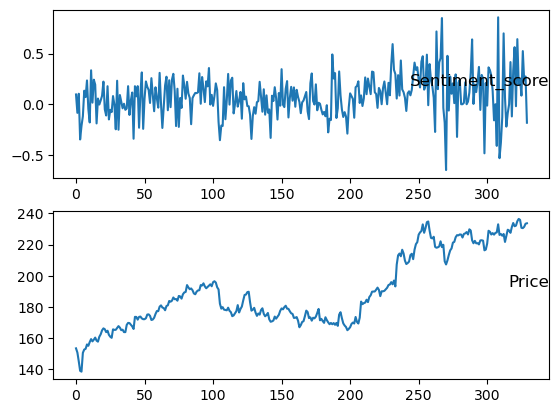

In [3]:
values = finalData.values
# specify columns to plot
groups = [1,2]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(finalData.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [4]:
finalData.set_index('DateTime',inplace=True)  
cols = finalData.columns.tolist()
cols = cols[-1:] + cols[:-1]
finalData = finalData[cols]
finalData

,Price,Sentiment_score
DateTime,,
2022-10-31 04:00:00,153.34,0.096446
2022-11-01 04:00:00,150.65,-0.085231
2022-11-02 04:00:00,145.03,0.103546
2022-11-03 04:00:00,138.88,-0.348146
2022-11-04 04:00:00,138.38,-0.214672
...,...,...
2024-10-23 04:00:00,230.76,0.085070
2024-10-24 04:00:00,230.57,0.525094
2024-10-25 04:00:00,231.41,0.233975


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(finalData.values)

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
n_hours = 3  #no of time lags
n_features = 1 #no of features
n_obs = n_hours*n_features

In [9]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
3,0.152497,0.494826,0.125076,0.374446,0.067788,0.499530,0.005097,0.200238
4,0.125076,0.374446,0.067788,0.499530,0.005097,0.200238,0.000000,0.288678
5,0.067788,0.499530,0.005097,0.200238,0.000000,0.288678,0.123242,0.352265
6,0.005097,0.200238,0.000000,0.288678,0.123242,0.352265,0.144852,0.519457
7,0.000000,0.288678,0.123242,0.352265,0.144852,0.519457,0.148930,0.477668


In [10]:
reframed = reframed.drop(reframed.columns[-1], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
3,0.152497,0.494826,0.125076,0.374446,0.067788,0.499530,0.005097
4,0.125076,0.374446,0.067788,0.499530,0.005097,0.200238,0.000000
5,0.067788,0.499530,0.005097,0.200238,0.000000,0.288678,0.123242
6,0.005097,0.200238,0.000000,0.288678,0.123242,0.352265,0.144852
7,0.000000,0.288678,0.123242,0.352265,0.144852,0.519457,0.148930


In [11]:
values = reframed.values
n_train_hours = 170
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(170, 7)

In [12]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [13]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 3, 1) (170,) (157, 3, 1) (157,)


In [14]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
43/43 - 1s - loss: 0.2425 - val_loss: 0.4152 - 1s/epoch - 25ms/step
Epoch 2/200
43/43 - 0s - loss: 0.0913 - val_loss: 0.2326 - 66ms/epoch - 2ms/step
Epoch 3/200
43/43 - 0s - loss: 0.0681 - val_loss: 0.2250 - 64ms/epoch - 1ms/step
Epoch 4/200
43/43 - 0s - loss: 0.0707 - val_loss: 0.2204 - 62ms/epoch - 1ms/step
Epoch 5/200
43/43 - 0s - loss: 0.0685 - val_loss: 0.2164 - 61ms/epoch - 1ms/step
Epoch 6/200
43/43 - 0s - loss: 0.0683 - val_loss: 0.2129 - 65ms/epoch - 2ms/step
Epoch 7/200
43/43 - 0s - loss: 0.0674 - val_loss: 0.2101 - 65ms/epoch - 2ms/step
Epoch 8/200
43/43 - 0s - loss: 0.0666 - val_loss: 0.2060 - 62ms/epoch - 1ms/step
Epoch 9/200
43/43 - 0s - loss: 0.0658 - val_loss: 0.2036 - 64ms/epoch - 1ms/step
Epoch 10/200
43/43 - 0s - loss: 0.0650 - val_loss: 0.1993 - 62ms/epoch - 1ms/step
Epoch 11/200
43/43 - 0s - loss: 0.0642 - val_loss: 0.1965 - 99ms/epoch - 2ms/step
Epoch 12/200
43/43 - 0s - loss: 0.0639 - val_loss: 0.1922 - 61ms/epoch - 1ms/step
Epoch 13/200
43/43 - 0s - 

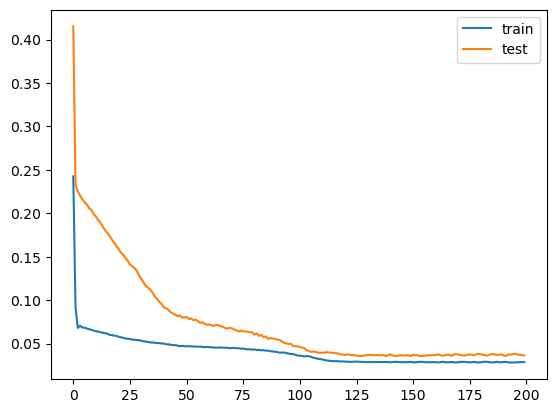

In [15]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

5/5 [==============================] - 0s 874us/step
Test RMSE: 4.871


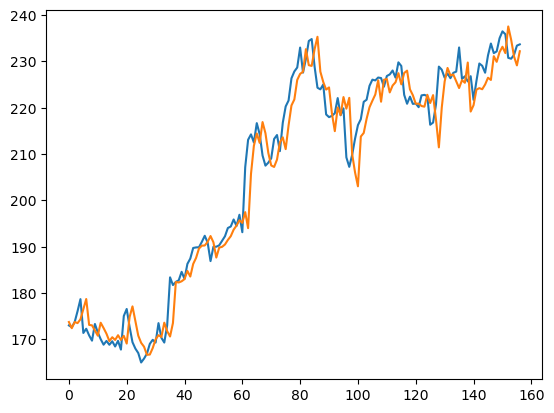

In [17]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

In [18]:
# Define CNN-LSTM model
model = Sequential()
# Add CNN layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_hours, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# Add LSTM layer
model.add(LSTM(50, activation='relu', return_sequences=False))
# Add Dense layer for output
model.add(Dense(1))
# Compile model
model.compile(optimizer='adam', loss='mae')

# Fit the model
history = model.fit(train_X, train_y, epochs=200, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Print model summary
model.summary()

ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)